# Dependencies


In [2]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from src.utils import (
    build_freqs,
    train_naive_bayes,
    predict_naive_bayes,
    cross_validation,
)

encoder = LabelEncoder()

# Preprocessing


In [3]:
df = pd.read_csv("../data/preprocessed/masakhane_afrisenti_twi_train_preprocessed.csv")
df["sentiment"] = encoder.fit_transform(df["label"])
df.head()

,tweet,label,sentiment
0,kako be shark but wo ti ewu,negative,0
1,br ne bayie nti na me supporti man city,negative,0
2,s3 woofis3 mada wafutuo tantan no 3y3wo s3mafa...,negative,0
3,wabɔdam anaa wo trumu yɛ nkate nkwan aseɛ,negative,0
4,enfa bi da bra 🤣🤣,negative,0


# Model Training


In [4]:
train_x = df["tweet"]
train_y = df["sentiment"]

In [5]:
freqs = build_freqs(train_x, train_y)

In [6]:
logprior, loglikelihood, vocab, classes = train_naive_bayes(freqs, train_x, train_y)

# Model Prediction


In [7]:
text = "3kom"

pred = predict_naive_bayes(text, logprior, loglikelihood, vocab, classes)
print(pred)

negative


# Model Validation


In [8]:
df2 = pd.read_csv(
    "../data/preprocessed/masakhane_afrisenti_twi_validation_preprocessed.csv"
)
df2["sentiment"] = encoder.fit_transform(df2["label"])
val_x = df2["tweet"]
val_y = df2["sentiment"]

In [9]:
alphas = [0.1, 0.01, 0.2, 0.02, 0.3, 0.03, 0.4, 0.5, 0.05]
best_alpha, sc = cross_validation(train_x, train_y, val_x, val_y, alphas)

# Retraining Using CV + Train set


In [10]:
full_train_x = np.concatenate([train_x, val_x])
full_train_y = np.concatenate([train_y, val_y])

In [11]:
freqs_full = build_freqs(full_train_x, full_train_y)

In [12]:
logprior_f, loglikelihood_f, vocab_f, classes_f = train_naive_bayes(
    freqs_full, full_train_x, full_train_y, alpha=best_alpha
)

# Test and Evaluation


In [13]:
df3 = pd.read_csv("../data/preprocessed/masakhane_afrisenti_twi_test_preprocessed.csv")
df3["sentiment"] = encoder.fit_transform(df3["label"])
test_x = df3["tweet"]
test_y = df3["sentiment"]

In [14]:
test_preds = [
    predict_naive_bayes(text, logprior_f, loglikelihood_f, vocab_f, classes_f)
    for text in test_x
]
test_preds_enc = encoder.transform(test_preds)
print(classification_report(test_y, test_preds_enc, target_names=encoder.classes_))


              precision    recall  f1-score   support

    negative       0.73      0.78      0.75       353
    positive       0.82      0.77      0.79       450

    accuracy                           0.77       803
   macro avg       0.77      0.77      0.77       803
weighted avg       0.78      0.77      0.77       803



Accuracy: 0.7733499377334994
Macro F1 score: 0.7715640669742782


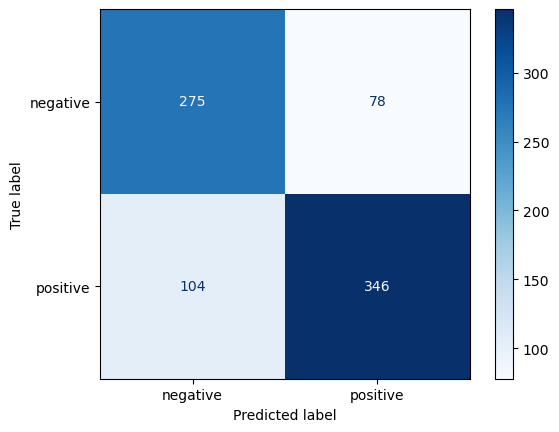

In [ ]:
acc = accuracy_score(test_y, test_preds_enc)
print("Accuracy:", acc)
f1_f = f1_score(test_y, test_preds_enc, average="macro")
print("Macro F1 score:",f1_f)

cm = confusion_matrix(test_y, test_preds_enc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap="Blues")
